In [1]:
# Import necessary packages
import pandas as pd 
import os
from helper_functions import date_to_decimal_year, rain_predictor
from plot_functions import eruption_counter, rain_plotter, by_strength
from el_nino_functions import elnino_strengths
import numpy as np

In [2]:
# Create path to data
folder_env_variable = 'MY_FOLDER_PATH'
default_folder_path = '/Users/jonathanquartin/Documents/Coding/GitHub/um_volcano_project/GALAPAGOS_DATA'

folder_path = os.environ.get(folder_env_variable, default_folder_path)

In [3]:
# Import tables
volcanic_events = pd.read_csv(os.path.join(folder_path, "eruptions_galapagos3.csv"))
rainfall = pd.read_csv(os.path.join(folder_path, "cleaned_precip_galap.csv"))

bellavista = pd.read_csv(os.path.join(folder_path, "climate_bellavista.csv"))
ayora = pd.read_csv(os.path.join(folder_path, "climate_puerto-ayora.csv"))

oni = pd.read_csv(os.path.join(folder_path, "oni.csv"))

In [4]:
# Drops events that occurs within 9 months of a previous event at their respective volcanic sites
volcanic_events = volcanic_events.drop(5)
volcanic_events = volcanic_events.drop(24)


Eruption data must have columns: 'Volcano' and 'Start'. 'Start' is the beginning date of the eruption given as a string-- YYYY-MM-DD.

Rainfall data must have columns: 'Date', 'Longitude', 'Latitude', and 'Precipitation'. 'Date' is given as a string YYYY-MM-DD and the other three columns are floats.

In [5]:
sites_dict = {'Wolf': (-91.35, .05, 'Wolf'), 'Fernandina': (-91.45, -.45, 'Fernandina'), 'Negra, Sierra': (-91.15, -.85, 'Sierra Negra'), 'Azul, Cerro': (-91.25, -.55, 'Cerro Azul') } # Long/lat pairs must exist in rainfall data
#volcanos = {'Wolf': (-91.20, 0.0, 'Wolf'), 'Fernandina': (-91.33, -0.22, 'Fernandina'), 'Negra, Sierra': (-91.17, -0.83, 'Sierra Negra'), 'Azul, Cerro': (-91.24, -0.55, 'Cerro Azul') } # Long/lat pairs must exist in rainfall data
quantiles = 3 # Number of bins to break up rainfall into
rolling_number = 90 # Number of days to average rainfall over
log_flag = True # If true, applies a log scaling to the data
by_season = False # Make true if you want to consider rainfall quantiles yearly, or False to consider rainfall quantiles across the entire date range
start = min(rainfall['Date'])
end = max(rainfall['Date'])
strengths = {}
anom_types = {'weak nina': -.5, 'moderate nina': -1, 'strong nina': -1.5, 'weak nino': .5, 'moderate nino': 1, 'strong nino': 1.5, 'very strong nino': 2}
for i in anom_types:
    if i == 'weak nina' or i == 'weak nino':
        strengths.update(elnino_strengths(oni, anom_types[i], i, 5))
    else:
        strengths.update(elnino_strengths(oni, anom_types[i], i, 3)) 

# Uncomment below to use rain predictor gauge location. This notebook combines pre-2000 predictions with post-2000 satellite data

compare_site = ayora  # Choose ayora or bellavista to compare rainfall to
print_summary = False # Make true if you want to see summary of regression
pred_rain = rain_predictor(rainfall, sites_dict, compare_site, rolling_number, print_summary)
rainfall_two = pred_rain[pred_rain['Date'] < start].copy()
rainfall = pd.concat([rainfall, rainfall_two])
start = min(rainfall['Date'])
end = max(rainfall['Date'])

# Picks out elninos/laninas within dates of rainfall data. Converts dates to decimals.
elninos = {'weak nina': [], 'moderate nina': [], 'strong nina': [], 'weak nino': [], 'moderate nino': [], 'strong nino': [], 'very strong nino': []}

if strengths != None:
    for j in strengths:
        for i in strengths[j]:
            if i[1] > start and i[0] < end:
                first = max(i[0], start)
                last = min(i[1], end)
                elninos[j].append([date_to_decimal_year(first), date_to_decimal_year(last)])



In [6]:
# Needed to combine pre and post 2000 data
rainfall = rainfall.reset_index(drop=True)

/Users/jonathanquartin/Documents/Coding/GitHub/precip-notebooks/plot_functions.py:128: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  volc_rain = volc_rain[~((volc_init['Decimal'] > erupt_dates[i]) & (volc_init['Decimal'] < erupt_dates[i] + recurs[pick]))].copy()
/Users/jonathanquartin/Documents/Coding/GitHub/precip-notebooks/plot_functions.py:128: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  volc_rain = volc_rain[~((volc_init['Decimal'] > erupt_dates[i]) & (volc_init['Decimal'] < erupt_dates[i] + recurs[pick]))].copy()
/Users/jonathanquartin/Documents/Coding/GitHub/precip-notebooks/plot_functions.py:128: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  volc_rain = volc_rain[~((volc_init['Decimal'] > erupt_dates[i]) & (volc_init['Decimal'] < erupt_dates[i] + recurs[pick]))].copy()
/Users/jonathanquartin/Documents/Coding/GitHub/precip-notebooks/plot_functions.py:128: UserWarning: Boolean Series 

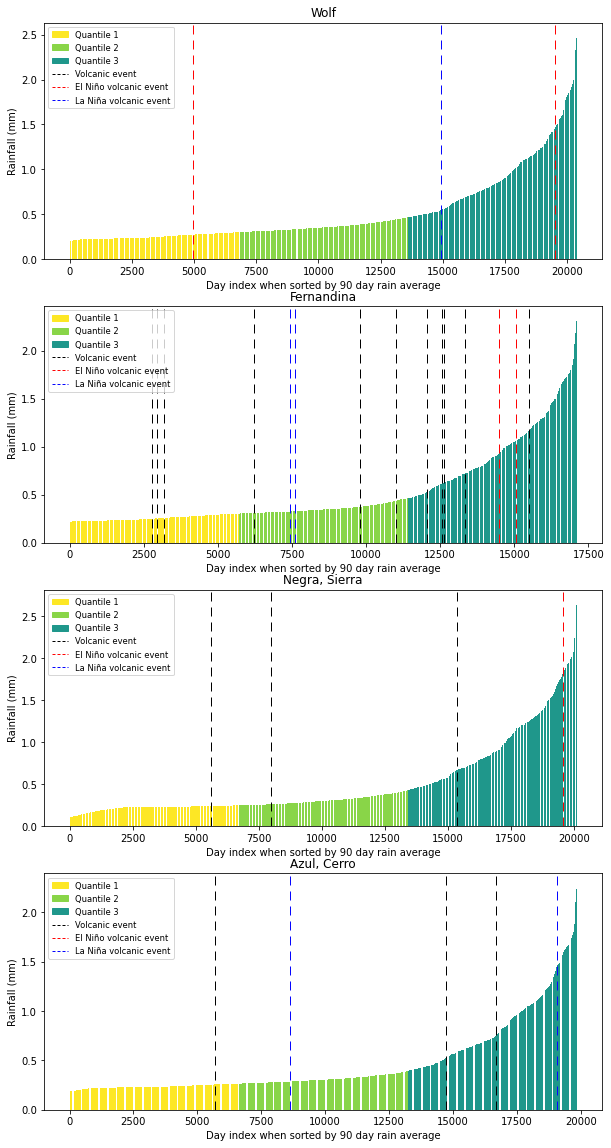

In [7]:
all_rain, event_rain = by_strength(sites_dict, volcanic_events, rainfall, quantiles, rolling_number, elninos, recur=True)